## Import Statements

In [1]:
import copy
import sys

import numpy as np
import pandas as pd
from PIL import Image

sys.path.append('../Mendota/')
import resnet

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim
from torchvision import transforms

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [2]:
data = pd.read_json('../Data/data.json')
labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [3]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Feature Correlation

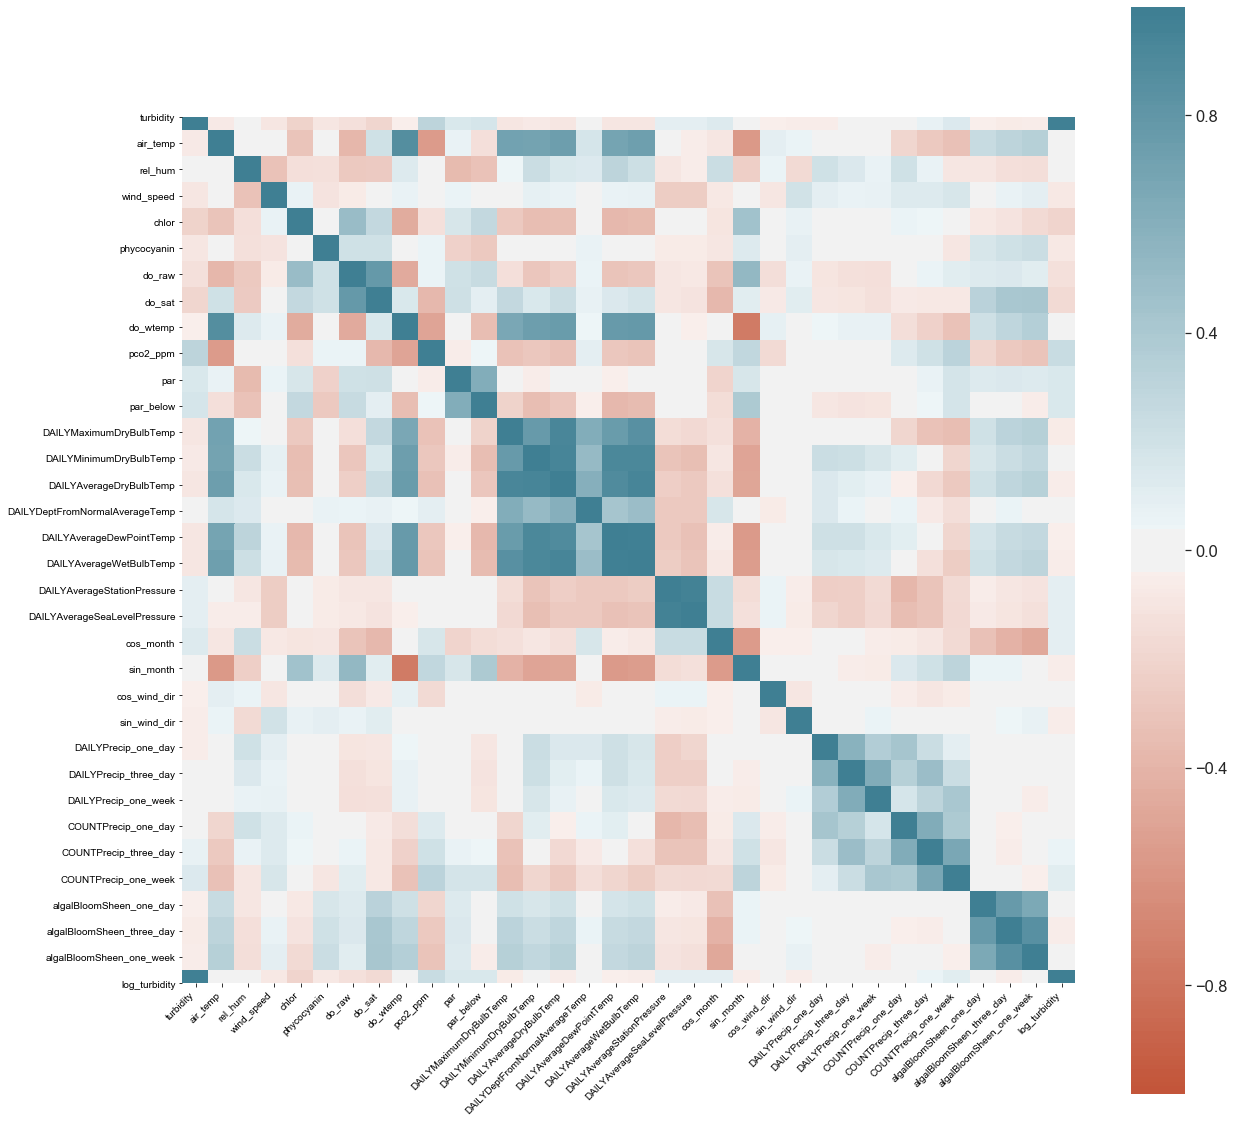

In [4]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Choose Correlated Features to Remove

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


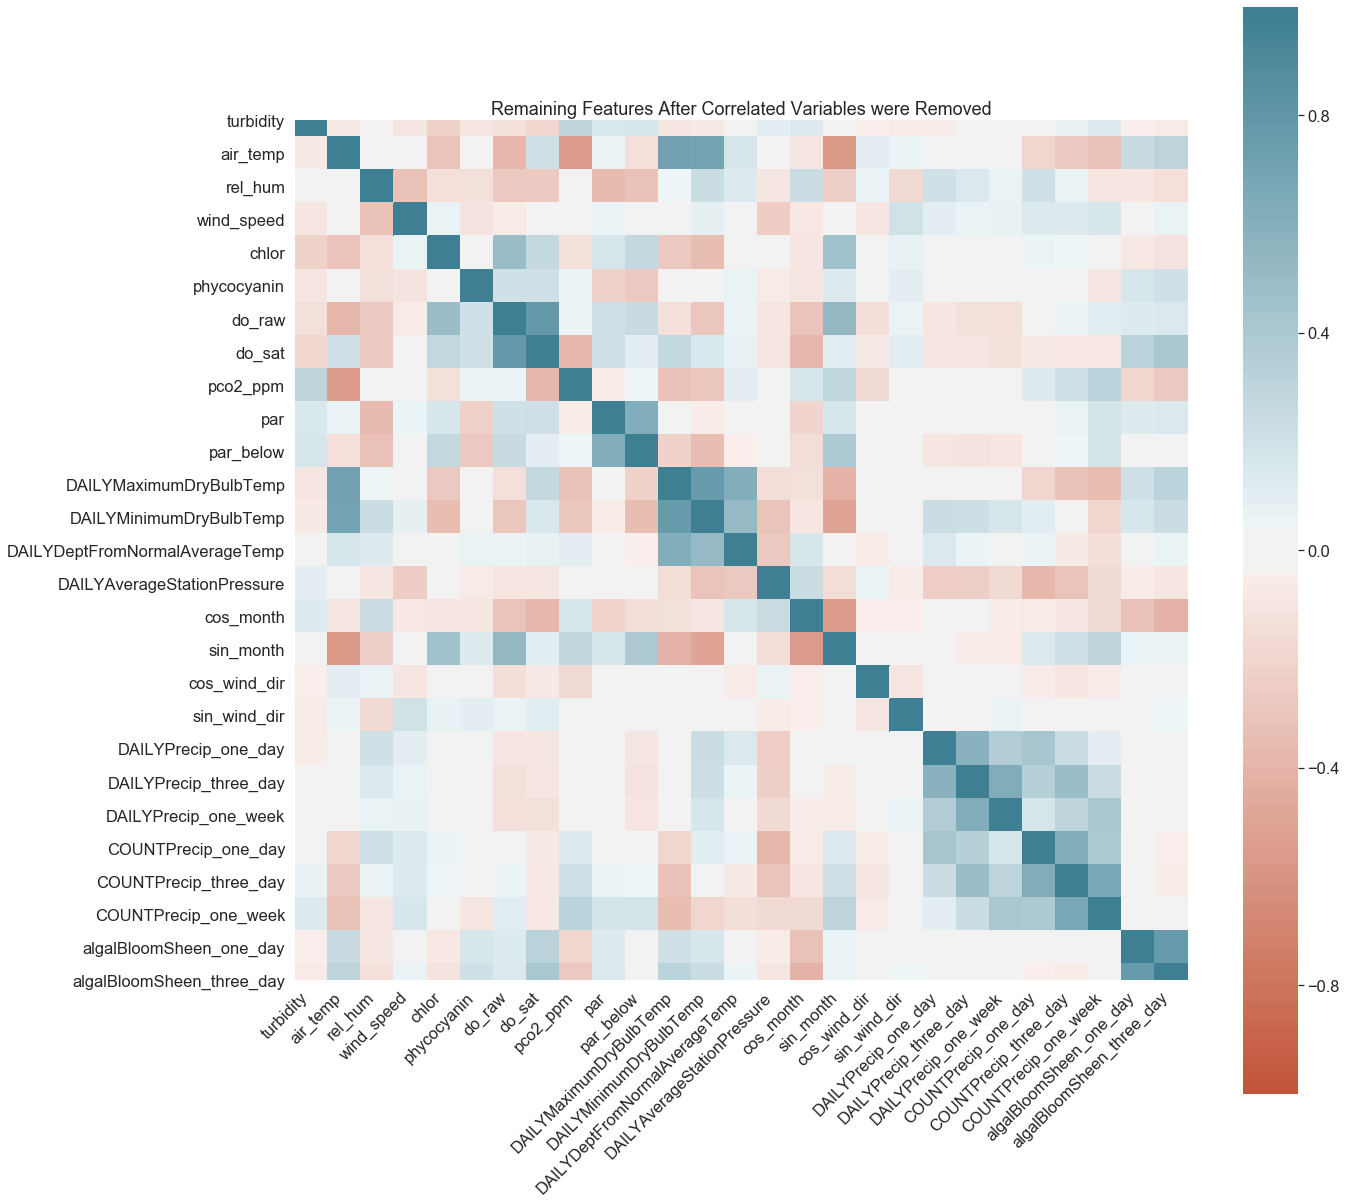

In [5]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])

new_corr = data[keep].corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

### Split Data

In [6]:
train_size = 0.7
data_aug = False
batch_size = 16

df = data[keep]
# df = df[df.index > '2016']   # only keep data after 2015
# labels = labels.loc[df.index]

X_train, X_test, y_train, y_test = train_test_split(
    df.values,
    labels.values.ravel(),
    train_size=train_size,
    shuffle=True,
    stratify=labels.values.ravel(),
    random_state=1337
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

### Define Model

In [7]:
log = LogisticRegression(
    penalty='l1',
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

## Evaluate

Accuracy: 0.7173
Balanced Accuracy: 0.7173
F1 Score: 0.6301

Confusion Matrix:


,0,1
0,91,37
1,17,46


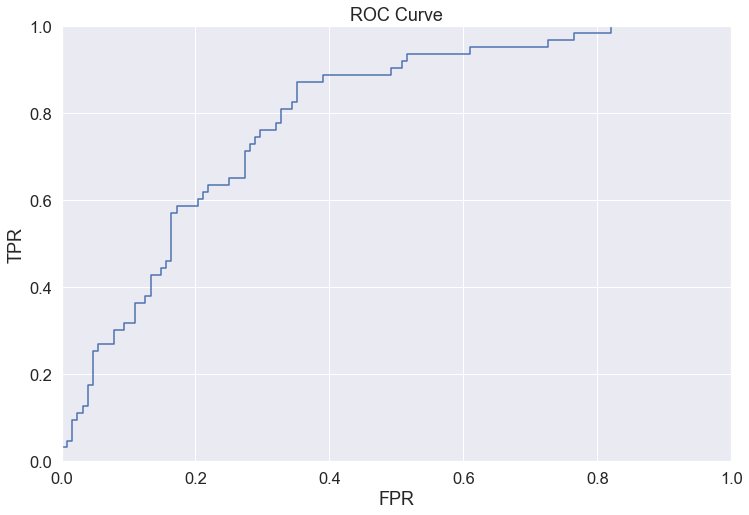

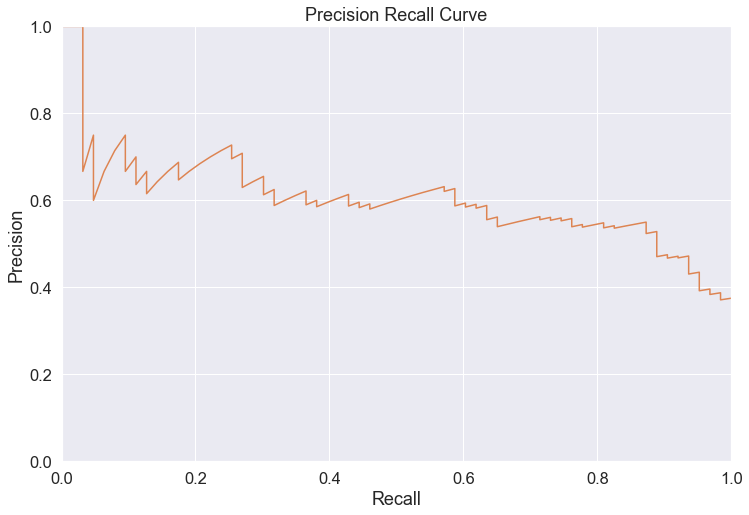

In [8]:
log.fit(X_train, y_train)
log_y_pred = log.predict(X_test)
log_y_prob = log.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, log_y_pred)
balanced_acc = accuracy_score(y_test, log_y_pred)
f1 = f1_score(y_test, log_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, log_y_pred))
fpr, tpr, _ = roc_curve(y_test, log_y_prob)
precision, recall, _ = precision_recall_curve(y_test, log_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [9]:
coef_sort_idx = np.argsort(-np.abs(log.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = log.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % log.coef_[0][idx], df.columns[idx])
    else:
        print('\t %0.4f' % log.coef_[0][idx], df.columns[idx])

Feature weighting for logistic regression

	-0.7966 do_raw
	 0.7129 do_sat
	 0.6529 algalBloomSheen_three_day
	-0.5408 pco2_ppm
	 0.4331 sin_month
	 0.3699 algalBloomSheen_one_day
	-0.2830 DAILYPrecip_three_day
	-0.2754 cos_month
	 0.2465 phycocyanin
	 0.2348 turbidity
	 0.2338 sin_wind_dir
	-0.1775 chlor
	 0.1725 par_below
	-0.1710 DAILYMaximumDryBulbTemp
	 0.0955 COUNTPrecip_one_week
	 0.0671 DAILYAverageStationPressure
	 0.0655 DAILYPrecip_one_day
	 0.0550 cos_wind_dir
	-0.0535 COUNTPrecip_one_day
	-0.0508 wind_speed
	 0.0409 rel_hum
	 0.0338 DAILYPrecip_one_week
	-0.0309 par
	 0.0000 air_temp
	 0.0000 DAILYMinimumDryBulbTemp
	 0.0000 DAILYDeptFromNormalAverageTemp
	 0.0000 COUNTPrecip_three_day


## Random Forest Classifer

### Define Model

In [10]:
rfc = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

### Evaluate

Accuracy: 0.7330
Balanced Accuracy: 0.7330
F1 Score: 0.6531

Confusion Matrix:


,0,1
0,92,36
1,15,48


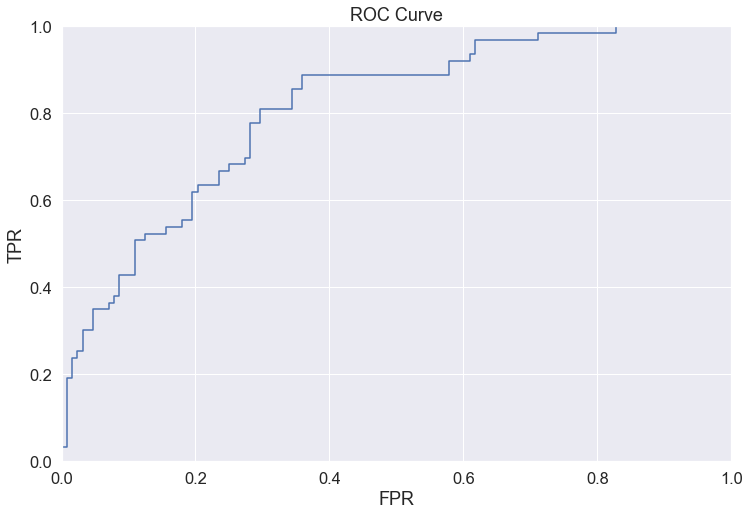

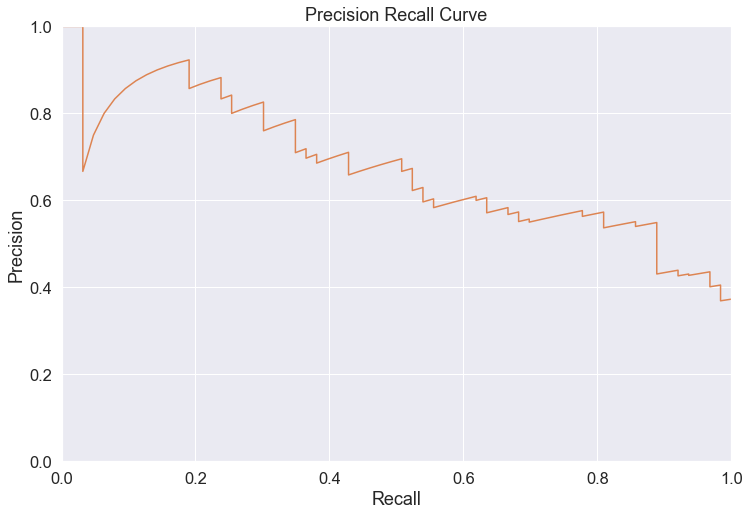

In [11]:
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_prob = rfc.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, rfc_y_pred)
balanced_acc = accuracy_score(y_test, rfc_y_pred)
f1 = f1_score(y_test, rfc_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, rfc_y_pred))
fpr, tpr, _ = roc_curve(y_test, rfc_y_prob)
precision, recall, _ = precision_recall_curve(y_test, rfc_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [12]:
coef_sort_idx = np.argsort(-np.abs(rfc.feature_importances_), kind='mergesort')

print('Feature weighting for Decision Trees with AdaBoost\n')
for idx in coef_sort_idx:
    coef = rfc.feature_importances_[idx]
    
    if coef < 0:
        print('\t%0.4f' % rfc.feature_importances_[idx], df.columns[idx])
    else:
        print('\t %0.4f' % rfc.feature_importances_[idx], df.columns[idx])

Feature weighting for Decision Trees with AdaBoost

	 0.1752 algalBloomSheen_three_day
	 0.1332 algalBloomSheen_one_day
	 0.0834 cos_month
	 0.0670 chlor
	 0.0656 do_sat
	 0.0493 phycocyanin
	 0.0428 pco2_ppm
	 0.0382 air_temp
	 0.0366 sin_month
	 0.0304 do_raw
	 0.0270 DAILYPrecip_one_week
	 0.0237 par_below
	 0.0235 turbidity
	 0.0232 wind_speed
	 0.0219 par
	 0.0208 rel_hum
	 0.0202 DAILYDeptFromNormalAverageTemp
	 0.0201 DAILYMinimumDryBulbTemp
	 0.0184 DAILYAverageStationPressure
	 0.0179 cos_wind_dir
	 0.0164 sin_wind_dir
	 0.0141 DAILYMaximumDryBulbTemp
	 0.0123 DAILYPrecip_three_day
	 0.0074 COUNTPrecip_one_week
	 0.0068 DAILYPrecip_one_day
	 0.0032 COUNTPrecip_three_day
	 0.0016 COUNTPrecip_one_day


## K-Nearest Neighbors

### Define Model

In [13]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',    # or distance
    p=2
)

### Evaluate

Accuracy: 0.7330
Balanced Accuracy: 0.7330
F1 Score: 0.6531

Confusion Matrix:


,0,1
0,92,36
1,15,48


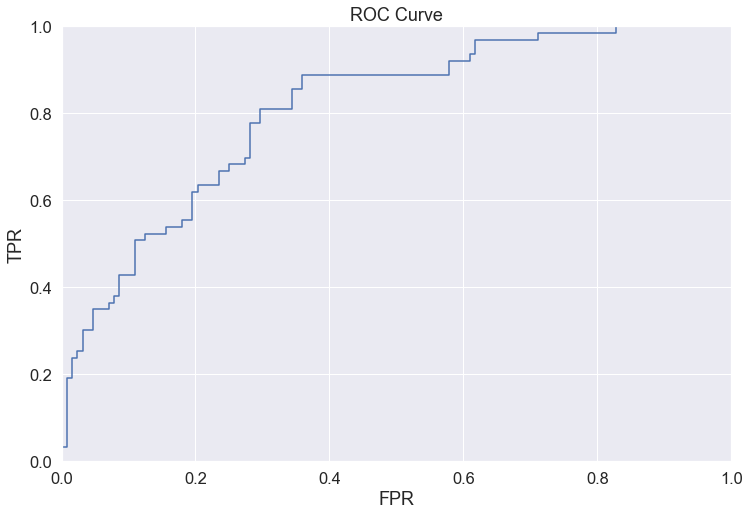

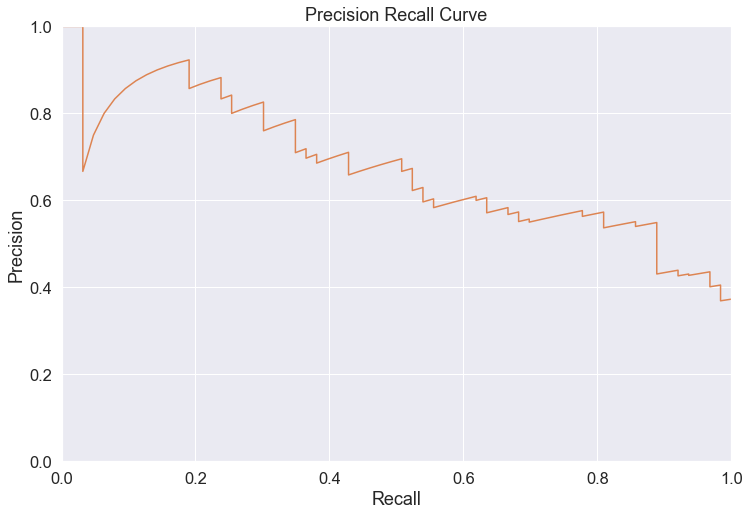

In [14]:
knn.fit(X_train, y_train)
knn_y_pred = rfc.predict(X_test)
knn_y_prob = rfc.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, knn_y_pred)
balanced_acc = accuracy_score(y_test, knn_y_pred)
f1 = f1_score(y_test, knn_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, knn_y_pred))
fpr, tpr, _ = roc_curve(y_test, knn_y_prob)
precision, recall, _ = precision_recall_curve(y_test, knn_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

## ResNet

## Create Data Loaders

In [15]:
class AlgalBloomDataset(data_utils.Dataset):

    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): numpy array of data samples
            labels (numpy array): numpy array of labels for the data samples
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        target = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, target

In [16]:
batch_size = 16
data_aug = False    # data augmentation

# zero pad data set. The input format for the resnet must be 5x5, or 6x6, or 7x7, etc.
pad_df = copy.deepcopy(df)
for i in range(36-df.shape[1]):
    pad_df[i] = [1 for _ in range(df.shape[0])]

vals = pad_df.values
data_reshape = []
for i in range(pad_df.shape[0]):
    # add rotated versions of the input to different channels
    data_reshape.append(vals[i].reshape(6, 6))

# Stratified split into training and holdout set
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    data_reshape,
    labels.values.ravel(),
    train_size=train_size,    # 80% of the data set
    shuffle=True,
    stratify=labels.values.ravel(),
    random_state=1337
)

X_train_res = np.asarray(X_train_res)
X_test_res = np.asarray(X_test_res)

print('Training set size:', X_train_res.shape)
print('Testing set size:', X_test_res.shape)

if data_aug:
    trnsfrm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406, 0.5), (0.229, 0.224, 0.225, 0.5)),
    ])
else:
    trnsfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406, 0.5), (0.229, 0.224, 0.225, 0.5)),
    ])

train_set = AlgalBloomDataset(X_train_res, y_train_res, trnsfrm)

test_set = AlgalBloomDataset(X_test_res, y_test_res, 
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406, 0.5), (0.229, 0.224, 0.225, 0.5)),
    ])
)

train_loader = data_utils.DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = data_utils.DataLoader(test_set, batch_size=len(test_set), shuffle=False)

# this data loader is used to get the indices of misclassified examples
missed_test_loader = data_utils.DataLoader(test_set, batch_size=1, shuffle=False)

Training set size: (445, 6, 6)
Testing set size: (191, 6, 6)


### Define ResNet Model

In [18]:
learning_rate = 0.1
num_epochs = 5
weighted = True

if weighted:
    class_weights = torch.Tensor([np.bincount(y_train.astype(int))[0] / len(y_train), 
                                  np.bincount(y_train.astype(int))[1] / len(y_train)])
else:
    class_weights=None

model = resnet.ResNet9()
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.SGD(model.parameters(), lr=learning_rate, nesterov=False, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[50, 100, 150, 200], gamma=0.1)

### Train ResNet

In [19]:
model.train()   # train model

loss_arr = []
acc_arr = []
f1_arr = []

for epoch in range(num_epochs):    
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    epoch_f1_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target)
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target).float() / len(target))
        epoch_f1_arr.append(f1_score(target, pred))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / len(epoch_acc_arr)
    epoch_f1 = sum(epoch_f1_arr) / len(epoch_f1_arr)
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    f1_arr.append(epoch_f1)
    
    print('Loss: {:0.4f} Acc: {:0.4f} F1: {:0.4f}\n'.format(epoch_loss, epoch_acc, epoch_f1))
    
    scheduler.step()


Epoch 1/5
----------
Loss: 27.4090 Acc: 0.6403 F1: 0.1533


Epoch 2/5
----------
Loss: 29.9506 Acc: 0.6872 F1: 0.2345


Epoch 3/5
----------
Loss: 20.5582 Acc: 0.6782 F1: 0.1558


Epoch 4/5
----------
Loss: 16.8806 Acc: 0.6966 F1: 0.1990


Epoch 5/5
----------
Loss: 13.8264 Acc: 0.6939 F1: 0.1914



### Plot Training Performance

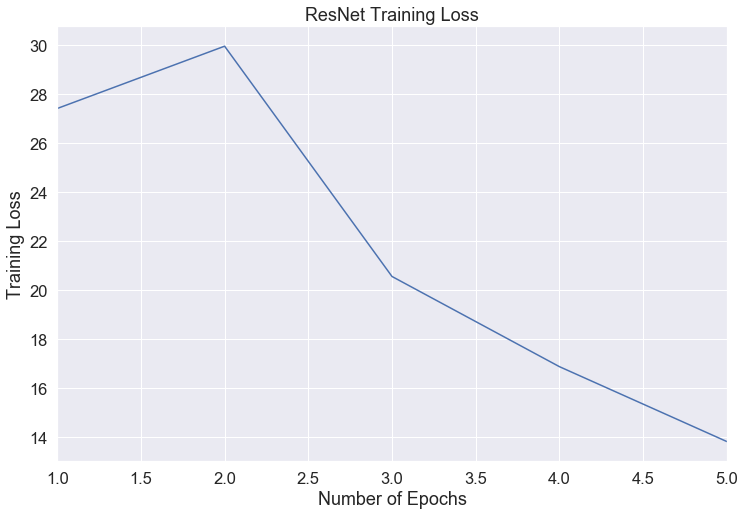

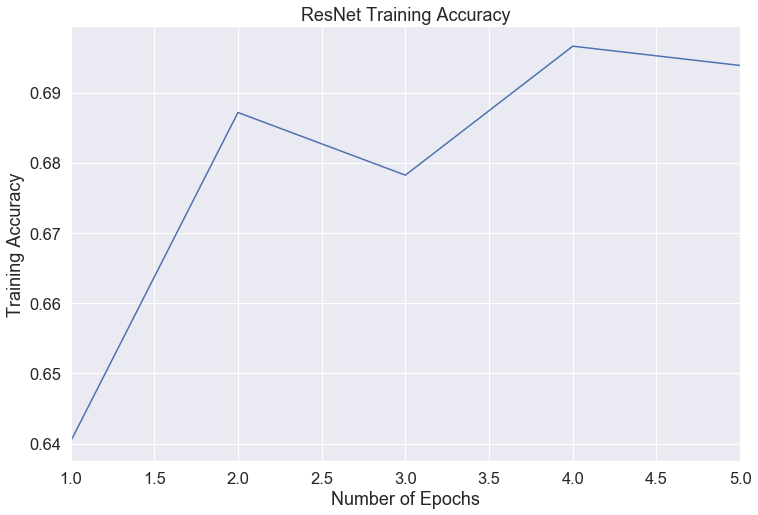

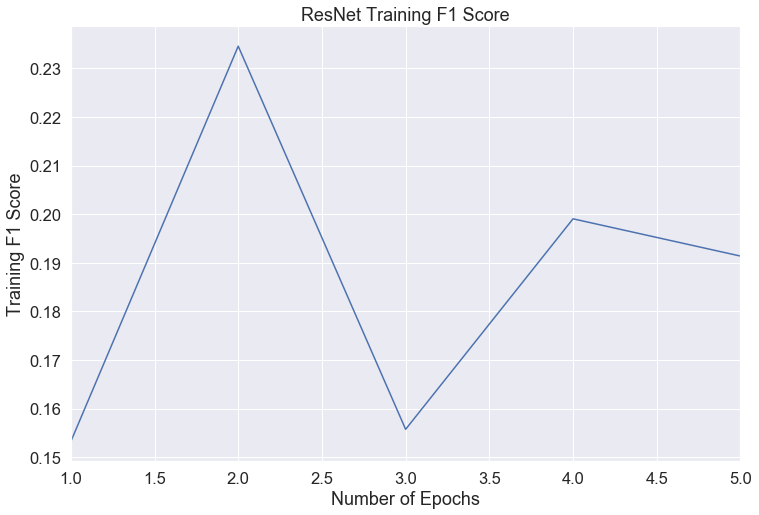

In [20]:
x = [i for i in range(1, num_epochs+1)]

plt.figure(figsize=(12, 8))
plt.plot(x, loss_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title('ResNet Training Loss')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, acc_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.title('ResNet Training Accuracy')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, f1_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training F1 Score')
plt.title('ResNet Training F1 Score')
plt.xlim([1, num_epochs])
plt.grid(True)

### Test ResNet

In [21]:
model.eval()    # test model

for samples, target in test_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target)

    _, pred = torch.max(output, 1)
    
acc = torch.sum(pred == target).float() / len(target)
f1 = f1_score(target, pred)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nTest Accuracy: {:0.4f}'.format(acc))
print('\nF1 Score: {:0.4f}'.format(f1))
print('Confusion Matrix:')
display(pd.DataFrame(conf_matrix))
print('\n\n')

res_missed_idx = []
idx = 0

for samples, target in missed_test_loader:
    output = model(samples)
    loss = criterion(output, target)

    _, pred = torch.max(output, 1)
    
    if pred != target:
        res_missed_idx.append(idx)
        
    idx += 1


Test Accuracy: 0.6021

F1 Score: 0.0732
Confusion Matrix:


,0,1
0,112,16
1,60,3


## Determine Misclassifications for Logistic Regression and Random Forest

In [17]:
log_missed_idx = np.where(log_y_pred != y_test)[0]   # index of misclassifications for logistic regression
rfc_missed_idx = np.where(rfc_y_pred != y_test)[0]   # index of misclassifications for random forest
knn_missed_idx = np.where(knn_y_pred != y_test)[0]   # index of misclassifications for k nearest neighbors

# count overlapping misclassifications and show dataframe of the instances
missed_idx = [log_missed_idx, knn_missed_idx] #res_missed_idx] #rfc_missed_idx]

if len(missed_idx[0]) <= len(missed_idx[1]):
    iter_idx = 0     # choose to itrate over the shorter of the two arrays
else:
    iter_idx = 1

overlap_idx = []

for i in range(len(missed_idx[iter_idx])):
    if missed_idx[iter_idx][i] in missed_idx[(len(missed_idx)-1)-iter_idx]:
        overlap_idx.append(missed_idx[iter_idx][i])

print(len(overlap_idx), 'out of', len(missed_idx[(len(missed_idx)-1)-iter_idx]), 
    'misclassifications were overlapped between logistic regression and k nearest neighbors\n\n')

missed_df = pd.DataFrame(X_test[overlap_idx], columns=df.columns)
missed_df.insert(loc=0, column='labels', value=y_test[overlap_idx])

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(missed_df)

47 out of 54 misclassifications were overlapped between logistic regression and random forest classifier




,labels,turbidity,air_temp,rel_hum,wind_speed,chlor,phycocyanin,do_raw,do_sat,pco2_ppm,par,par_below,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageStationPressure,cos_month,sin_month,cos_wind_dir,sin_wind_dir,DAILYPrecip_one_day,DAILYPrecip_three_day,DAILYPrecip_one_week,COUNTPrecip_one_day,COUNTPrecip_three_day,COUNTPrecip_one_week,algalBloomSheen_one_day,algalBloomSheen_three_day
0,0,-0.052984,0.743552,-0.342579,-0.323762,-0.483746,0.176547,-0.350984,0.233028,-0.632540,0.690785,-0.113329,0.770775,0.747381,-0.037200,0.178138,-0.676144,-0.323735,1.177250,-0.969893,-0.407104,-0.667468,0.152981,-0.941060,-0.415267,0.420519,1.445779,0.946203
1,1,1.400854,1.002047,0.889863,0.378235,-0.445177,-0.716470,-0.975314,-0.746617,0.667966,0.165479,0.130861,1.492003,1.963782,2.009319,-0.486147,-1.039464,0.470904,0.205986,1.265557,-0.407104,1.987764,0.652796,-0.941060,0.567679,0.420519,-0.691669,0.032840
2,0,0.415892,0.495769,0.529732,-0.261777,1.033216,-0.161884,-0.037311,0.384840,-0.894840,0.745811,0.551846,-0.568647,0.240547,-1.462184,1.211469,-0.676144,-0.323735,1.516306,0.033161,-0.407104,0.333685,0.097446,-0.941060,-0.415267,-0.197075,1.445779,0.946203
3,0,-0.208561,0.277075,-2.348431,2.543725,-0.517118,0.618168,0.673682,1.244252,-0.328902,0.606121,-0.061203,0.976840,1.051481,0.993639,-1.814716,-1.039464,0.470904,-0.692832,1.090644,1.228606,0.812498,1.670937,1.062632,0.567679,0.420519,1.445779,1.859566
4,0,0.076535,0.426368,1.169536,1.716965,-0.433131,0.299024,-1.252793,-1.026564,-0.211656,0.228995,-0.330933,-0.053484,1.152848,-0.370707,-2.405192,-0.676144,-0.323735,-1.306211,-0.642301,2.084208,1.204253,0.254795,1.062632,0.567679,-0.197075,1.445779,0.946203
5,0,-0.578726,0.485491,1.136074,0.008164,-0.616724,0.358596,-0.691274,-0.517356,-0.655075,-0.406988,-0.410480,-0.877744,0.037813,0.038597,0.325757,1.672395,-1.118373,-0.314746,1.232349,-0.029632,0.058005,-0.596741,1.062632,1.550625,-0.197075,1.445779,0.032840
6,0,-0.833014,0.431676,0.495101,-0.190208,-0.358861,0.856468,1.022806,1.609817,-0.084666,-1.463911,-0.899417,0.564711,0.037813,-0.704214,0.842422,-0.676144,-0.323735,-0.853676,0.991234,-0.407104,-0.681978,-0.356089,-0.941060,-1.398213,-1.432262,1.445779,1.859566
7,0,-0.173154,-1.061504,-2.088418,-0.850379,0.769458,-0.445889,0.736505,-0.271051,0.133023,3.005855,3.779230,-1.702004,-2.394989,-1.401546,0.916232,-0.676144,1.265543,0.164743,-1.453606,-0.407104,-0.145127,0.699075,-0.941060,0.567679,1.655706,1.445779,0.946203
8,0,0.797323,0.680473,-1.037665,-0.005855,-0.135178,-0.012076,0.515616,1.465420,-1.071995,1.431995,-0.322425,0.255613,-0.570387,-1.447024,2.318611,-0.676144,-0.323735,-0.951490,-1.099788,-0.407104,-0.681978,-0.707811,-0.941060,-1.398213,-0.814668,-0.691669,0.032840
9,0,0.773182,0.512733,-1.065448,-1.281520,-0.714896,8.328149,-0.586683,-0.491365,-0.084666,-1.463911,-0.899417,-1.392906,-0.367654,-0.719373,0.104328,-0.676144,1.265543,1.333756,0.575948,1.329265,0.319176,-0.420880,1.062632,-0.415267,-0.814668,-0.691669,0.032840
